## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
from pylab import rcParams
import scipy as sp

import sklearn as sk
from sklearn import neighbors, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import svm

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000240F3243248>,
      dtype=object)

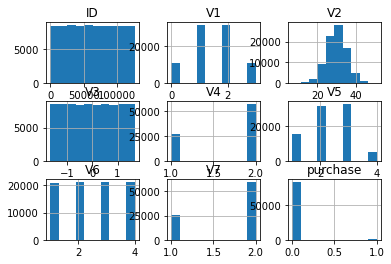

In [2]:
# First look at dataset
train_data.hist()

In [3]:
# Split dataset in experimental group and control group and check shape. 

promotion_group = train_data[train_data.Promotion == 'Yes']
n_promotion = promotion_group.shape[0]
print(promotion_group.shape)
print(n_promotion)

control_group = train_data[train_data.Promotion == 'No']
n_control = control_group.shape[0]
print(control_group.shape)
print(n_control)

(42364, 10)
42364
(42170, 10)
42170


In [4]:
# Calculate p for purchase in experiment and control group. 

p_promotion = list(promotion_group.groupby('purchase').size())[1] / promotion_group.shape[0]
purchasers_promotion = promotion_group.groupby('purchase').size()[1]
print(p_promotion)
print(purchasers_promotion)

p_control = list(control_group.groupby('purchase').size())[1] / control_group.shape[0]
purchasers_control = control_group.groupby('purchase').size()[1]
print(p_control)
print(purchasers_control)

0.017019167217448776
721
0.007564619397676073
319


In [5]:
# Compute IRR

IRR = p_promotion - p_control
print(IRR)


0.009454547819772702


In [6]:
# Compute NIR

NIR = (10 * purchasers_promotion - 0.15 * n_promotion) - 10 * purchasers_control
print(NIR)

-2334.5999999999995


In [7]:
# Plot correlation of features

train_data_corr = train_data.drop(['ID', 'Promotion'], axis = 1)

corr = train_data_corr.corr()
table = corr.style.background_gradient(cmap='Blues').format('{0:,.3f}')
table

,purchase,V1,V2,V3,V4,V5,V6,V7
purchase,1.000,-0.005,-0.002,-0.006,0.032,0.008,-0.002,-0.001
V1,-0.005,1.000,-0.002,0.004,0.003,-0.001,-0.004,0.001
V2,-0.002,-0.002,1.000,0.001,0.003,-0.001,-0.004,-0.002
V3,-0.006,0.004,0.001,1.000,0.004,-0.002,0.004,0.001
V4,0.032,0.003,0.003,0.004,1.000,0.003,0.003,-0.003
V5,0.008,-0.001,-0.001,-0.002,0.003,1.000,-0.003,0.004
V6,-0.002,-0.004,-0.004,0.004,0.003,-0.003,1.000,-0.001
V7,-0.001,0.001,-0.002,0.001,-0.003,0.004,-0.001,1.000


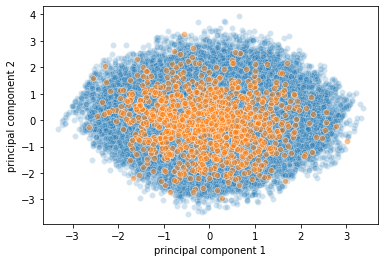

In [16]:
# Apply PCA to visualize the different features of all customers. 

# Separate features and target
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']
x = train_data.loc[:, features].values
y = train_data.loc[:, ['purchase']].values

# Apply Standardscaler
x = StandardScaler().fit_transform(x)

# Make new DF with PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2'])

# Concat DF with purchase values
finalDf = pd.concat([principalDf, train_data[['purchase']]], axis = 1)

# Prepare different alpha values and plot
finalDf["alpha"] = np.where(finalDf.purchase == 1, 0.5, 0.2)

ax = sns.scatterplot(x="principal component 1", y="principal component 2",
                     data=finalDf[finalDf.alpha == 0.2], alpha=0.2)
sns.scatterplot(x="principal component 1", y="principal component 2", 
                data=finalDf[finalDf.alpha == 0.5], alpha=0.5, ax=ax)


In [17]:
# Apply Machine Learning: KNeighbors: 

# Split data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# Clustering using KNeighbors
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train, y_train.ravel())

clf.score(X_test, y_test)

0.9874896942323548

In [14]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    # Select X and y from training data
    X = train_data.drop(['purchase', 'Promotion', 'ID'], axis = 1)
    y = train_data['purchase']
    
    
    # Apply Smote due to imbalanced dataset (note: applying Standardscaler make no improvements)
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    
    # Fit and predict KNeigborsClassifier
    clf = KNeighborsClassifier(n_neighbors=10)
    print('Clf is fitting...')
    clf.fit(X_res, y_res)

    print('Clf is now predicting...')
    purchase = clf.predict(df)
    
    promotion = pd.Series(purchase).replace({0:'No', 1:'Yes'})
    print('Computations are ready')
    
    return promotion

In [15]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Clf is fitting...
Clf is now predicting...
Computations are ready
Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0081.

Your nir with this strategy is -232.10.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.008095887188106594, -232.10000000000002)